In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import exploratory_analysis as ea
%matplotlib inline

In [75]:
df = pd.read_csv('../data/train.csv', low_memory=False)
y = df.pop('top_school_final')

In [76]:
df, df_valid, y, y_valid = train_test_split(df, y, random_state=123)

### Clean SAT

In [77]:
df['Highest Composite SAT Score'] = df['Highest Composite SAT Score'].apply(lambda x: None if x>2400 or x<600 else x)

In [78]:
df['SAT_total_temp'] = df['Highest SAT Scores'].apply(lambda x: ea.parseSAT(x) if type(x)==str else x)

In [79]:
ea.finalizeSAT(df)

In [80]:
SAT_median = df['SAT_total_final'].median()
df['SAT_total_final'].fillna(value=SAT_median, inplace=True)

### SAT (times taken)

In [81]:
df['SAT_times_taken'] = df['How many times did you take the official SAT?'].copy()

In [82]:
SAT_times_median = df['SAT_times_taken'].median()
df['SAT_times_taken'].fillna(value=SAT_times_median, inplace=True)

### Clean High School GPA

In [83]:
df['High School GPA'] = df['High School GPA'].apply(lambda x: np.nan if x==0 or x>100 else x)

In [84]:
df['High School GPA'] = df['High School GPA'].apply(lambda x: np.nan if x<=2 else x)

In [85]:
GPA_median = df[df['High School GPA']<=4]['High School GPA'].median()
df['High School GPA'] = df['High School GPA'].apply(lambda x: GPA_median if x>4 else x)

In [86]:
df['High School GPA'].fillna(value=GPA_median, inplace=True)

### Gender

In [87]:
df['Male'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

### Ethnicity

In [88]:
df['Ethnicity2'] = df['Ethnicity'].apply(lambda x: ea.parseEthnicity(x) if type(x)==str else x)

In [89]:
df['Ethnicity_Asian'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'asian' in x else 0)
df['Ethnicity_Black'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'black / african american' in x else 0)
df['Ethnicity_Hispanic'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'hispanic' in x else 0)
df['Ethnicity_White'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'white non-hispanic' in x else 0)
df['Ethnicity_Pacific'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'native hawaiian / pacific islander' in x else 0)
df['Ethnicity_NativeAm'] = df['Ethnicity2'].apply(lambda x: 1 if type(x)==list and 'native american' in x else 0)

### High School Activities / Leadership / Honors

In [90]:
leader_words = ['leader','president','founder']
arts_words = ['arts', 'music', 'jazz', 'band', 'orchestra', 'choir', 'drama', 'theater']
award_words = ['award', 'scholarship', 'achievement', 'prize']
community_words = ['volunteer', 'community','cleanup', 'ngo', 'environment', 'humanity','green', 'charity']
academic_words = ['science', 'math', 'engineering']
gov_words = ['debate', 'model', 'government']
diversity_words = ['alliance', 'multicultural', 'diversity']
race_words = ['naacp','asian','jewish','german','french','japanese','italian','chinese']

In [91]:
ecc_colnames = ['leader','arts','award','community','academic','gov','diversity','race_ecc']
ecc_words = [leader_words, arts_words, award_words, community_words, academic_words, gov_words, diversity_words, race_words]
for colname, words in zip(ecc_colnames, ecc_words):
    df[colname] = df['High School Extracurricular Activities'].apply(lambda x: ea.parseECC(x, words))

### Sports

In [92]:
all_sports = list(df['High School Sports Played'].apply(ea.getAllSports))
unique_sports = ea.getUniqueSports(all_sports)

In [93]:
# Initialize dummy variables for each sport category, set to 0s.
ea.makeSportsDummies(df, unique_sports)

In [94]:
# Fill in the dummy variables for each sport category accordingly (1 if that sport was played)
ea.parseSports(df, unique_sports)

In [95]:
# Create a varsity dummy variable that indicates if someone played sports at a varsity level
df['sportsVarsity'] = df['High School Sports Played'].apply(lambda x: ea.parseVarsity(x, unique_sports))
# Create a varsity dummy variable that indicates if someone was a captain of a sport
df['sportsCaptain'] = df['High School Sports Played'].apply(lambda x: ea.parseCaptain(x, unique_sports))

### Home Country

In [96]:
df['Home Country'] = df['Home Country'].apply(lambda x:re.search('[[]\S+[]]\s[[]\S+[]]\s(.+)', x).group(1)
                                              if type(x)==str else x)

In [97]:
df['Home Country_US'] = df['Home Country'].apply(lambda x: 1 if x=='United States' else 0)

### Academic Performance in HS

In [98]:
df = pd.get_dummies(df,columns=['Academic Performance in High School'], prefix='HS')

### Final Columns

In [220]:
def getFinalCols(df):
    final_cols = ['SAT_total_final', 'SAT_times_taken', 'High School GPA', 'Male', 'leader', 'arts', 'award',
                  'community','academic','gov','diversity','race_ecc','Home Country_US','sportsVarsity','sportsCaptain']

    ethnicity_cols = [col for col in df.columns if col.find('Ethnicity_')>-1]
    HS_perf_cols = [col for col in df.columns if col.find('HS_')>-1]
#     sports_cols = [col for col in df.columns if col.find('sports_')>-1]
#     sports_cols.extend(['sportsVarsity', 'sportsCaptain'])
#     essay_cols = ['essay_topic'+str(i) for i in range(1,8)]

    final_cols.extend(ethnicity_cols)
    final_cols.extend(HS_perf_cols)
#     final_cols.extend(sports_cols)
#     final_cols.extend(essay_cols)
    return final_cols

In [221]:
final_cols = getFinalCols(df)

### StandardScale

In [61]:
scaler = StandardScaler()
# df = pd.DataFrame(scaler.fit_transform(df[final_cols]), columns=final_cols)

# Modeling: Identifying Important Variables

### Shrinking beta coefficients to 0 using L1 regularization (Logistic Regression) in sklearn

In [251]:
def getBetas(df, y, alphas):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    betas = []
    for a in alphas:
        lr = LogisticRegression(penalty='l1', C=a)
        lr.fit(X_scaled, y)
        betas.append(lr.coef_[0])  
    
    return betas

In [252]:
alphas = np.logspace(4,-2,10)
betas = getBetas(df[final_cols], y, alphas)

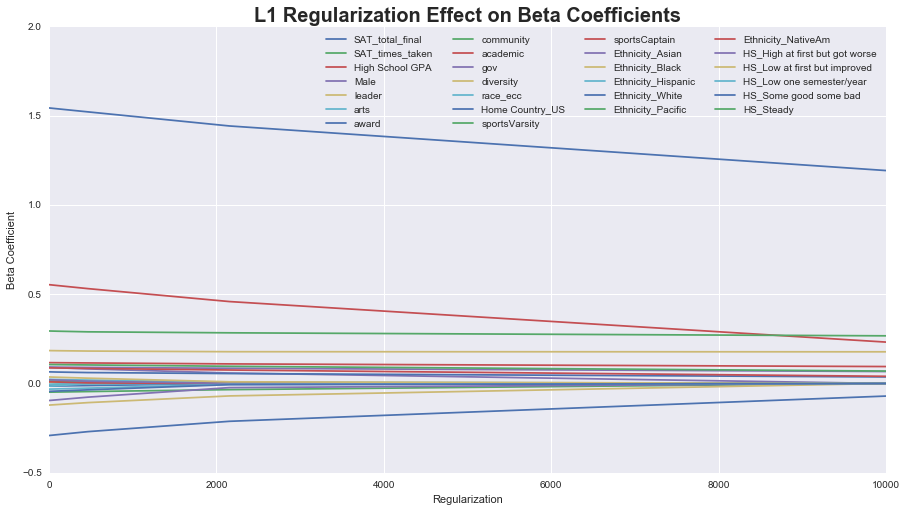

In [256]:
betas_t = np.array(betas).T

fig = plt.figure(figsize=(15,8))
for i,b in enumerate(betas_t):
    plt.plot(alphas[::-1], b, label=final_cols[i])
plt.legend(ncol=4)
plt.title('L1 Regularization Effect on Beta Coefficients', fontdict={'fontsize':20, 'fontweight':'bold'})
plt.xlabel('Regularization')
plt.ylabel('Beta Coefficient')

In [272]:
goodcols = []
for i,val in enumerate(betas[-2]):
    if (abs(val)>0.005):
        goodcols.append(final_cols[i])
print goodcols

['SAT_total_final', 'SAT_times_taken', 'High School GPA', 'Male', 'leader', 'arts', 'award', 'academic', 'gov', 'sportsVarsity', 'sportsCaptain', 'Ethnicity_Asian', 'Ethnicity_Black', 'Ethnicity_White', 'HS_Low at first but improved', 'HS_Low one semester/year', 'HS_Some good some bad', 'HS_Steady']


#### Using statsmodel.api

Now let's re-run the logistic regression (only using goodcols) using statsmodels.api and identify the less informative variables. We arbitrarily set a p value of 0.05 as a cutoff point.

In [267]:
logit = sm.Logit(y, df[goodcols])

# fit the model
result = logit.fit(maxiter=100)
result.summary()

Optimization terminated successfully.
         Current function value: 0.325080
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       top_school_final   No. Observations:                 9693
Model:                          Logit   Df Residuals:                     9675
Method:                           MLE   Df Model:                           17
Date:                Wed, 16 Nov 2016   Pseudo R-squ.:                  0.1772
Time:                        13:27:18   Log-Likelihood:                -3151.0
converged:                       True   LL-Null:                       -3829.7
                                        LLR p-value:                2.163e-278
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
SAT_total_final                  0.0029      0.000     15.624      0.000         0.003     0.003
SAT_times_taken                 -0.6077      0.068     -8.877      0.000        -0.742    -0.474
High School GPA                 -1.8774      0.101    -18.508      0.000        -2.076    -1.679
Male                             0.2122      0.073      2.894      0.004         0.068     0.356
leader                           0.7999      0.099      8.053      0.000         0.605     0.995
arts                             0.0478      0.102      0.468      0.640        -0.152     0.248
award                            0.1398      0.102      1.376      0.169        -0.059     0.339
academic                         0.8242      0.124      6.657      0.000         0.582     1.067
gov                              0.4075      0.105      3.876      0.000         0.201     0.614
sportsVarsity                    0.3100      0.103      3.004      0.003         0.108     0.512
sportsCaptain                    0.3817      0.120      3.175      0.001         0.146     0.617
Ethnicity_Asian                  0.0766      0.088      0.866      0.387        -0.097     0.250
Ethnicity_Black                 -0.9329      0.122     -7.651      0.000        -1.172    -0.694
Ethnicity_White                 -0.5989      0.080     -7.479      0.000        -0.756    -0.442
HS_Low at first but improved    -0.4813      0.201     -2.394      0.017        -0.875    -0.087
HS_Low one semester/year        -0.3315      0.257     -1.288      0.198        -0.836     0.173
HS_Some good some bad           -1.1165      0.247     -4.520      0.000        -1.601    -0.632
HS_Steady                        0.7523      0.092      8.146      0.000         0.571     0.933
================================================================================================
"""

In [275]:
for col in ['arts', 'Ethnicity_Asian','HS_Low one semester/year']:
    goodcols.remove(col)

### Random Forests

In [276]:
params = {
    'min_samples_split': range(2,5),
    'min_weight_fraction_leaf': [0,0.03,0.05],
    'min_samples_leaf': range(1,4)
}
gs = GridSearchCV(RandomForestClassifier(), param_grid=params)
gs.fit(df[goodcols], y)
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

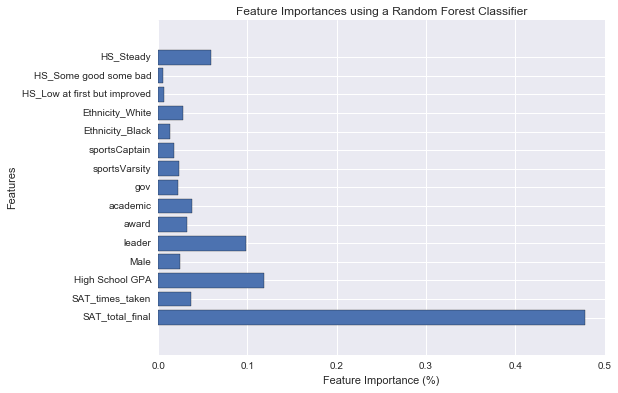

In [285]:
fig = plt.figure(figsize=(8,6))
plt.barh(range(len(goodcols)), gs.best_estimator_.feature_importances_, tick_label=goodcols, align='center')
plt.title('Feature Importances using a Random Forest Classifier')
plt.xlabel('Feature Importance (%)')
plt.ylabel('Features')

In [286]:
# goodcols_rf = []
# for i,val in enumerate(rf.feature_importances_):
#     if val>0.01:
#         goodcols_rf.append(final_cols[i])

In [287]:
for col in ['HS_Some good some bad', 'HS_Low at first but improved']:
    goodcols.remove(col)

In [288]:
print goodcols

['SAT_total_final', 'SAT_times_taken', 'High School GPA', 'Male', 'leader', 'award', 'academic', 'gov', 'sportsVarsity', 'sportsCaptain', 'Ethnicity_Black', 'Ethnicity_White', 'HS_Steady']
